<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstsom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Organizing Maps (SOMs)

Here we will be training a 3x3 SOM using simulated storm data (used previously for our CNN notebook). Following SOM training, we will create composite maps to visualize the grouping of our storm dat across the SOM lattice.

In [1]:
import warnings
from itertools import product
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

In [2]:
! pip install minisom

In [3]:
from minisom import MiniSom, asymptotic_decay

In [4]:
! wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2024-03-26 04:13:01--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc.2’

current_SP3hourly_2 100%[===================>] 104.33M  25.2MB/s    in 5.0s    

2024-03-26 04:13:07 (21.0 MB/s) - ‘current_SP3hourly_20110427.nc.2’ saved [109400556/109400556]



In [5]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

In [6]:
dsfull = xr.open_dataset('current_SP3hourly_20110427.nc')

In [7]:
dsfull

<xarray.Dataset>
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime      (starttime) float64 ...
    x_speed      (starttime) int64 ...
    y_speed      (starttime) int64 ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 ...
    uh03_grid    (starttime, y, x) float32 ...
    ctt_grid     (starttime, y, x) float32 ...
    dbz_grid     (starttime, y, x) float32 ...
    mask         (starttime, y, x) int64 ...
    row_indices  (starttime, y, x) int64 ...
    col_indices  (starttime, y, x) int64 ...
    lats         (starttime, y, x) float32 ...
    lons         (starttime, y, x) float32 ...

### Select one variable and fit 3x3 SOM.

In [8]:
# we will use dbz/simulated radar reflectivity
dsfull['dbz_grid']

<xarray.DataArray 'dbz_grid' (starttime: 2224, y: 32, x: 32)>
[2277376 values with dtype=float32]
Coordinates:
  * starttime  (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime    (starttime) float64 ...
    x_speed    (starttime) int64 ...
    y_speed    (starttime) int64 ...
Dimensions without coordinates: y, x

In [9]:
# each grid cell (x, y) will be feature for each sample
# let's reshape accordingly (samples, features)
ds = dsfull['dbz_grid'].stack(features=('y','x'))

In [10]:
ds

<xarray.DataArray 'dbz_grid' (starttime: 2224, features: 1024)>
array([[-35.      , -35.      , -35.      , ...,  13.949479,  12.911252,
         10.474219],
       [-35.      , -35.      , -35.      , ...,  15.252525,   9.551773,
        -12.005707],
       [-35.      , -35.      , -35.      , ..., -35.      , -35.      ,
        -35.      ],
       ...,
       [-29.150763, -33.773006, -35.      , ..., -12.28549 , -21.292902,
        -30.720982],
       [ 24.57368 ,  13.765106,  14.084679, ...,  29.180717,  28.653072,
         28.988672],
       [ 13.142024,  16.35466 ,  17.247124, ...,  25.714262,  23.523518,
         26.171114]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime    (starttime) float64 ...
    x_speed    (starttime) int64 ...
    y_speed    (starttime) int64 ...
  * features   (features) object MultiIndex
  * y          (features) int64 0 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31 31 31
  * x          (features) int64 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30 31

In [11]:
# normalization of our training data (note each variable should be individually processed!)
ds_scaled = z_score(ds)
# convert to numpy array for use with minisom
ds_scaled = ds_scaled.values

# SOMs time!

In [12]:
# SOM hyperparameters

# set som lattice dimensions (i.e., number of nodes)
som_grid_rows = 3
som_grid_columns = 3

# number of weights per node
input_length = ds_scaled.shape[1]

# Spread of the neighborhood function, needs to be adequate to the dimensions
# of the map. (rows/columns minus 1 usually)
sigma = 2.0

# initial learning rate (at the iteration t we have learning_rate(t) =
# learning_rate / (1 + t/T) where T is #num_iteration/2)
learning_rate = 0.5

# Function that reduces learning_rate and sigma at each iteration
# the default function is (asymptotic_decay):
# learning_rate / (1+t/(max_iterarations/2))
decay_function = asymptotic_decay

# Function that weights the neighborhood of a position in the map.
# Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle',
# which takes in sigma.
neighborhood_function = 'gaussian'

# Topology of the map; Possible values: 'rectangular', 'hexagonal'
topology = 'rectangular'

# Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
activation_distance = 'euclidean'

# Random seed to use for reproducibility. Using 1.
random_seed = 1

In [13]:
# lets create our som object with preset hyperparameters
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed)

In [14]:
# some training hyperparameters
epochs = 10000
random_order = True
verbose = True

In [15]:
# let's initialize the weights
som.random_weights_init(ds_scaled)
# som.pca_weights_init(ds_scaled)

In [16]:
# just vieweing the random weights
som.get_weights()

array([[[-1.03932369, -0.52485353, -0.45033053, ...,  1.44800484,
          1.15314555,  0.67560792],
        [-1.13367176, -1.07694936, -0.99383473, ..., -0.53624862,
         -0.68146396, -0.8066346 ],
        [-0.56518501, -0.67954421,  0.48663226, ..., -0.83972389,
         -0.71767533, -0.5213986 ]],

       [[ 0.14352404, -0.00613375,  0.1140321 , ...,  1.00546145,
          1.19885612,  1.45407248],
        [ 1.06086552,  1.05668283,  1.11776388, ...,  0.76450711,
          0.80701393,  0.81377196],
        [ 0.42516214,  0.57606477,  0.67520875, ..., -0.4708569 ,
         -1.11932063, -0.92772609]],

       [[ 1.0284909 ,  1.10503435,  1.01927316, ...,  0.3609637 ,
          0.12877603,  0.0352688 ],
        [-2.53033018, -2.53033018, -2.53033018, ..., -0.74737114,
          0.13885419, -0.23701039],
        [-0.74855947, -0.71945316, -0.72111547, ..., -1.73292708,
         -1.68697429, -1.63191032]]])

In [17]:
# now train!
som.train(
    ds_scaled,
    epochs,
    random_order,
    verbose
    )

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 21.499034895366535


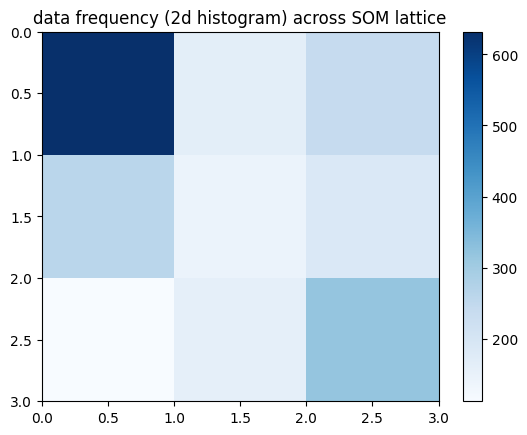

In [18]:
plt.figure()
frequencies = som.activation_response(ds_scaled)
plt.pcolormesh(frequencies, cmap='Blues')
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

In [19]:
# grabbing indices from SOM

# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_grid_rows), range(som_grid_columns))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(ds_scaled):
    winmap[som.winner(x)].append(i)

In [20]:
som_keys = list(winmap.keys())
print(f"Number of SOM nodes: {len(som_keys)}")

Number of SOM nodes: 9


In [21]:
ds

<xarray.DataArray 'dbz_grid' (starttime: 2224, features: 1024)>
array([[-35.      , -35.      , -35.      , ...,  13.949479,  12.911252,
         10.474219],
       [-35.      , -35.      , -35.      , ...,  15.252525,   9.551773,
        -12.005707],
       [-35.      , -35.      , -35.      , ..., -35.      , -35.      ,
        -35.      ],
       ...,
       [-29.150763, -33.773006, -35.      , ..., -12.28549 , -21.292902,
        -30.720982],
       [ 24.57368 ,  13.765106,  14.084679, ...,  29.180717,  28.653072,
         28.988672],
       [ 13.142024,  16.35466 ,  17.247124, ...,  25.714262,  23.523518,
         26.171114]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime    (starttime) float64 ...
    x_speed    (starttime) int64 ...
    y_speed    (starttime) int64 ...
  * features   (features) object MultiIndex
  * y          (features) int64 0 0 0 0 0 0 0 0 0 ... 31 31 31 31 31 31 31 31 31
  * x          (features) int64 0 1 2 3 4 5 6 7 8 ... 23 24 25 26 27 28 29 30 31

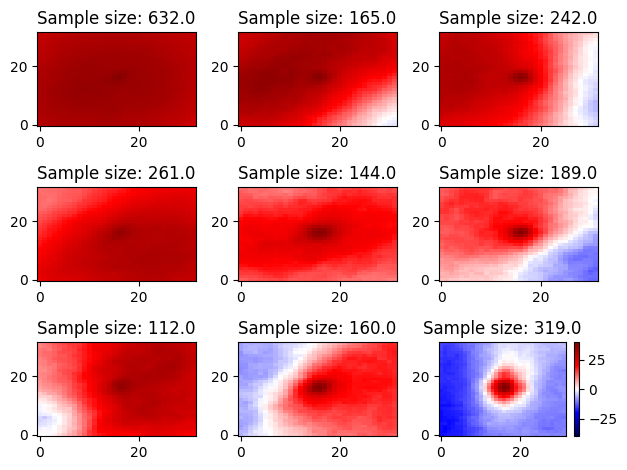

In [22]:
# view all SOM composite maps
# (this cell takes a few minutes to run, especially if SOM lattice is large)

# grab values for grid
lats = ds.unstack('features').y
lons = ds.unstack('features').x

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns)

# (1) loop through the SOM neurons,
# (2) grab data samples using SOM indices,
# (3) compute the mean for each SOM neuron, plot each
for map_num in range(len(som_keys)):

    # the data
    temp_data = ds.unstack('features')[
        np.array(winmap[som_keys[map_num]])].mean(dim="starttime", skipna=True).values

    # plot
    cs = axs[som_keys[map_num][0], som_keys[map_num][1]].pcolormesh(
        lons, lats, temp_data, cmap="seismic", vmin=-40, vmax=40)

    # title
    axs[som_keys[map_num][0], som_keys[map_num][1]].set_title(
        f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)

    # add plot stuff
    axs[som_keys[map_num][0], som_keys[map_num][1]].margins(x=0, y=0)

# plot the figure containing all plots
plt.colorbar(cs)
plt.tight_layout()
plt.show()

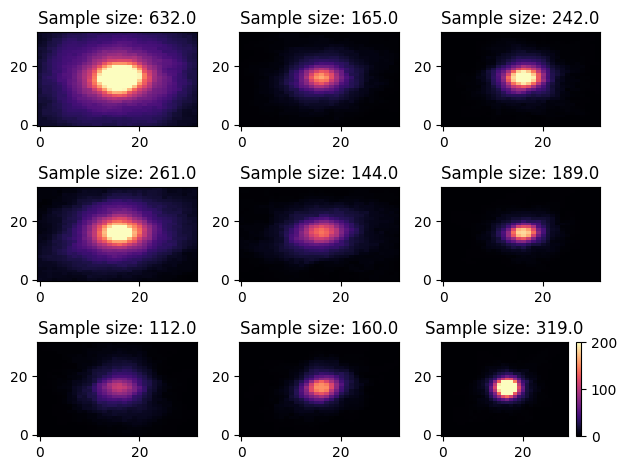

In [23]:
# view all SOM composite maps
# (this cell takes a few minutes to run, especially if SOM lattice is large)

# grab values for grid
lats = ds.unstack('features').y
lons = ds.unstack('features').x

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns)

# (1) loop through the SOM neurons,
# (2) grab data samples using SOM indices,
# (3) compute the sum of another variable at each SOM neuron, plot each
for map_num in range(len(som_keys)):

    # the data
    temp_data = dsfull['mask'][
        np.array(winmap[som_keys[map_num]])].sum(dim="starttime", skipna=True).values

    # plot
    cs = axs[som_keys[map_num][0], som_keys[map_num][1]].pcolormesh(
        lons, lats, temp_data, cmap="magma", vmin=0, vmax=200)

    # title
    axs[som_keys[map_num][0], som_keys[map_num][1]].set_title(
        f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)

    # add plot stuff
    axs[som_keys[map_num][0], som_keys[map_num][1]].margins(x=0, y=0)

# plot the figure containing all plots
plt.colorbar(cs)
plt.tight_layout()
plt.show()